# CE-40959: Advanced Machine Learning
## HW1 - Black-box Meta Learning (100 points)

In this notebook, you are going to implement a black-box meta learner using the `Omniglot` dataset.

Please write your code in specified sections and do not change anything else. If you have a question regarding this homework, please ask it on the Quera.

Also, it is recommended to use Google Colab to do this homework. You can connect to your drive using the code below:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Import Required libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torch.nn as nn
import math
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

## Introduction

In Meta-Learning literature and in the meta-training phase, you are given some batches which consist of `support` and `query` sets. you train your model in a way that by using a support set you could predict query set labels correctly.

In this homework, you are going to implement such meta-learner like the below architecture. In this model, at each step, you give all your support images and one query to the network simultaneously (query at the end) and you expect that the model predicts query label based on your inputs.


<br><br>

<div style="text-align:center;"><img src="https://drive.google.com/uc?export=view&id=1Au9GF7FB_IChrMLmvM0z4RBPP1R3oPgY" width=300></div>

<br><br>

Don't worry if you didn't understand the architecture. we are going to explain it step by step.

So if our meta-learning is K-shot N-way then each batch will consist of N*K support images with labels and one query image which we have its label in the meta-training phase.

First we should build dataset it this way that each batch return N*K+1 images

The Omniglot data set is designed for developing more human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people.

Train and test dataset contains 964 and 659 classes, respectively. Torchvision-based Omniglot dataset is ordered and every 20 images in a row belong to one class.

In [ ]:
# Meta learning parameters.

N = 5
K = 1

## Prepare dataset (25 points)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = True, transform = transform)
test_dataset = torchvision.datasets.Omniglot('./data/omniglot/', download = True, background = False, transform = transform)

train_labels = np.repeat(np.arange(964), 20)
test_labels = np.repeat(np.arange(659), 20)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot/omniglot-py/images_background.zip to ./data/omniglot/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot/omniglot-py/images_evaluation.zip to ./data/omniglot/omniglot-py


To build a dataloader, we should have a class that yields indexes of selected data in the dataset for every iteration and pass it to the `batch_sampler` attribute of dataloader.

Complete below code based on this pseudocode:


1.   select `N` classes randomly from all classes
2.   select `1` class from `N` selected classes as query-contained class
3.   select `K` images from other `N-1` classes independently and randomly
4.   select `K+1` images from the query-contained class independently and randomly
5.   shuffle dataset indexes, but don't forget to put query index at the last of the list



In [ ]:
class BatchSampler(object):
    """
    BatchSampler: yield a batch of indexes at each iteration.
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    """
    def __init__(self, labels, classes_per_it, num_samples, iterations, batch_size):
        """
        Initialize the BatchSampler object
        Arguments:
        - labels: array of labels of dataset.
        - classes_per_it: number of random classes for each iteration
        - num_samples: number of samples for each iteration for each class
        - iterations: number of iterations (episodes) per epoch
        - batch_size: number of batches per iteration
        """
        super(BatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations
        self.batch_size = batch_size
        self.classes = np.unique(self.labels)

    def __iter__(self):
        '''
        yield a batch of indexes
        '''

        for it in range(self.iterations):
            total_batch_indexes = np.array([])

            #################################################################################
            #                  COMPLETE THE FOLLOWING SECTION (25 points)                   #
            #################################################################################
            # feel free to add/edit initialization part of sampler.
            #################################################################################
            for b in range(self.batch_size):
                batch = np.array([])
                test_index=0
                classes=np.random.choice(self.classes,self.classes_per_it,False)
                query_contained_class = random.choice(classes)
                for c in classes:
                    sample_indexes=[]
                    c*=20
                    if  c/20 != query_contained_class:
                      sample_indexes = np.random.randint(c, c+20, size=self.sample_per_class)
                      batch=np.append(batch,sample_indexes)
                    else:
                      sample_indexes = np.random.randint(c, c+20, size=self.sample_per_class+1)
                      batch=np.append(batch,sample_indexes[:-1])
                      test_index=sample_indexes[-1]
                    np.random.shuffle(batch)
                batch=np.append(batch,test_index)
                total_batch_indexes=np.append(total_batch_indexes,batch)

            #################################################################################
            #                                   THE END                                     #
            #################################################################################

            yield total_batch_indexes.astype(int)

    def __len__(self):
        return self.iterations


In [ ]:
iterations = 5000
batch_size = 32

train_sampler = BatchSampler(labels=train_labels, classes_per_it=N,
                              num_samples=K, iterations=iterations,
                              batch_size=batch_size)

test_sampler = BatchSampler(labels=test_labels, classes_per_it=N,
                              num_samples=K, iterations=iterations,
                              batch_size=batch_size)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler)

## Model (50 points)

Let's Build our model. the first block of our model is one encoder which is given below. you are going to implement other blocks of networks with a given explanation

In [ ]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class OmniglotNet(nn.Module):
    '''
    source: https://github.com/jakesnell/prototypical-networks/blob/f0c48808e496989d01db59f86d4449d7aee9ab0c/protonets/models/few_shot.py#L62-L84
    '''
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        super(OmniglotNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(x_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, z_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

The whole network consists of two major blocks:


1.   Causal Attention
2.   Temporal Convolution

The first block is `Causal Attention`:


<div style="text-align:center;"><img src="https://drive.google.com/uc?export=view&id=19lWuKzYTRry-UBog838o7dWYVL-r54WF" width=500></div>

<br><br>

The mechanism is so similar to self-attention (if you don't have any information about self-attention, see [this link](https://www.geeksforgeeks.org/self-attention-in-nlp/)) with one difference. the `masked softmax` has been replaced by `softmax`. It means that at each timestep when you calculate weights of the attention mechanism, you do it with just past keys/values.

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, key_size, value_size):
        super(AttentionBlock, self).__init__()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (2.5 points)                  #
        #################################################################################
        self.keys = nn.Linear(in_channels, key_size)
        self.values = nn.Linear(in_channels, value_size)
        self.query = nn.Linear(in_channels, key_size)

        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        self.softmax_temp = math.sqrt(key_size) #don't forget to apply temperature before calculating softmax.

    def forward(self, x):
        # x is dim (N, T, in_channels) where N is the batch_size, and T is the sequence length
        mask = np.array([[1 if i>j else 0 for i in range(x.shape[1])] for j in range(x.shape[1])])
        mask = torch.ByteTensor(mask).to(x.device)

      
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (7.5 points)                  #
        #################################################################################
        keys = self.keys(x) 
        values = self.values(x)
        query = self.query(x)

        temperature = torch.bmm(query, torch.transpose(keys, 1, 2)).data.masked_fill_(mask, -float('inf'))
        temperature = F.softmax(temperature / self.softmax_temp, dim=1) 
        avg = torch.bmm(temperature, values) 
        
        return torch.concat((x, avg), dim=-1) 
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

The second block is `Temporal Convolution`:

a Temporal Convolution consists of a series of `Dense Blocks` whose dilation rates increase exponentially until their receptive field exceeds the desired sequence length. For example first time when you apply this block, sequence length is (N*K+1) and dilation is 2.
to sum up, what you will do is this:

<div style="text-align:center;"><img src="https://drive.google.com/uc?export=view&id=1_mWTFiZNQlN4sMTWp2GqolSSzNTAFJuh" width=1000></div>

<br>
Dense Block pseduocode is:
<br><br>

<div style="text-align:center;"><img src="https://drive.google.com/uc?export=view&id=1T2q6KugqBEcwSyJAAGymTaXTe__MGsv3" width=1000></div>

<br>
The `CausalConv` code is given.

<br>

In [ ]:
class CasualConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super(CasualConv1d, self).__init__()

        self.pad = nn.ConstantPad1d((dilation, 0), 0)
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=2, dilation=dilation)

    def forward(self, x):
        return self.conv1d(self.pad(x))

class DenseBlock(nn.Module):

    def __init__(self, in_channels, out_channels, dilation):
        super().__init__()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (2.5 points)                  #
        #################################################################################
        self.casualconv1 = CasualConv1d(in_channels,out_channels,dilation=dilation)
        self.casualconv2 = CasualConv1d(in_channels,out_channels,dilation=dilation)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, x):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################
        activations = torch.tanh(self.casualconv1(x)) * torch.sigmoid(self.casualconv2(x))
        return torch.concat((x, activations), dim=1)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################



class TemporalConvolutionBlock(nn.Module):

    def __init__(self, sequence_length, in_channels, dense_block_out_channels):
        super().__init__()

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (2.5 points)                  #
        #################################################################################
        dense_blcks = []
        for i in range (1, int(np.ceil(np.log(sequence_length)))+1):
          dense_blcks.append(DenseBlock(in_channels+dense_block_out_channels*(i-1), out_channels = dense_block_out_channels, dilation = 2**i))

        self.dense_blocks = nn.ModuleList(dense_blcks)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def forward(self, x):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        x = torch.transpose(x, 1, 2)
        for block in self.dense_blocks:
            x = block(x)
        return torch.transpose(x, 1, 2)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        


In [ ]:
# The general mechanism of the network is as follows:
# Your input shape is (B*S, C, H, W). B is batch size, S is sequence length, C is channel, H is height and W is width of your image.
# first you should pass your input to "OmniglotNet" network to get feature vectors per data. shape: (B*S, V). V is feature vector size.
# then separate B and S dimensions and concat one-hot labels with your data. Shape: (B, S, V + N). N is your meta-learner parameter (number of classes per batch)
# pass it to a attention block with key size of 64 and value size of 32. shape: (B, S, v1)
# pass it to a temporal convolution block which consists of dense blocks with 128 output channels. shape: (B, S, v2)
# pass it to a attention block with key size of 256 and value size of 128. shape: (B, S, v3)
# pass it to a temporal convolution block which consists of dense blocks with 128 output channels. shape: (B, S, v4)
# pass it to a attention block with key size of 512 and value size of 256. shape: (B, S, v5)
# pass it to a Linear block with N outputs to predict labels. shape: (B, S, N)
# return last index of sequence which is related to query (second dimension). shape: (B, N)

class Network(nn.Module):
    def __init__(self, N, K):
        super(Network, self).__init__()

        self.N = N
        self.K = K
        self.encoder = OmniglotNet()
        channels_number = 64 + N

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        num_filters = int (np.ceil(np.log(N * K + 1)))
        self.attention1 = AttentionBlock(channels_number, 64, 32)
        channels_number += 32
        self.tc1 = TemporalConvolutionBlock(N * K + 1, channels_number, 128)
        channels_number += num_filters * 128
        self.attention2 = AttentionBlock(channels_number, 256, 128)
        channels_number += 128
        self.tc2 = TemporalConvolutionBlock(N * K + 1,channels_number, 128)
        channels_number += num_filters * 128
        self.attention3 = AttentionBlock(channels_number, 512, 256)
        channels_number += 256
        self.fc = nn.Linear(channels_number, N)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################


    def forward(self, input, labels):

        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (10 points)                   #
        #################################################################################
        # input shape is (B*S, C, H, W)
        # labels shape is (B, S, N)
        # output shape is (N, N)
        # calculate output by given description
        #################################################################################

        input = self.encoder(input)
        seq_len = N*K+1
        input = input.reshape((input.shape[0]//seq_len, seq_len, -1))
        input = torch.concat((input, labels),-1)
        input = self.attention1(input)
        input = self.tc1(input)
        input = self.attention2(input)
        input = self.tc2(input)
        input = self.attention3(input)
        input = self.fc(input)
        return input[:,-1,:]
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

## Train (15 points)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network(N, K)
model = model.to(device)
checkpoint = torch.load("/content/drive/MyDrive/MSC1400_1/AML/HW1/Practical/Q6/checkpoints/model_final.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [25]:
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.0001
model = Network(N,K).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
epochs = 10

path = "/content/drive/MyDrive/MSC1400_1/AML/HW1/Practical/Q6/checkpoints/"


criterion = nn.CrossEntropyLoss()

train_acc = []
losses = []
        
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs))
    loader_iter = iter(train_dataloader)
 
    for _,batch in tqdm(enumerate(loader_iter), total=len(loader_iter)):
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (15 points)                   #
        #################################################################################
        # prepare your data as input to your model.
        # extract query label (last image label in each batch) for loss function.
        # convert your labels to one-hot form and don't forget to set all elements of
        # one-hotted query label to zero (it's trivial that we shouldn't give
        # the output of the network to model as input!).
        # train your model.
        # save loss of each iteration
        #################################################################################
        optimizer.zero_grad()
        x, y = batch
        seq_size = N * K + 1
        one_hots = []
        last_targets = []
        for i in range (0,len(y),N+1):
          labels = set(y[i:i+N+1].tolist())
          map = {l : j  for j, l in enumerate(labels)}
          for j in range (N+1):
            y[i+j] = map[y[i+j].item()]

        one_hots = nn.functional.one_hot(y, num_classes = N)
        one_hots = one_hots.reshape((one_hots.shape[0]//seq_size, seq_size, -1))
        one_hots [:,-1,:] = torch.zeros(N)
        last_targets = []
        for i in range(one_hots.shape[0]):
          last_targets.append(y[(seq_size)*(i+1)-1])
        
        last_targets = torch.Tensor(last_targets).type(torch.LongTensor).to(device)
        one_hots = one_hots.to(device)
        x = x.to(device)
        outputs= model(x, one_hots)
        loss = criterion(outputs, last_targets)
        loss.backward()
        optimizer.step()
        mean = torch.mean(loss).cpu().data.item()
        losses.append(mean)
        _, preds = outputs.max(1)
        acc = torch.eq(preds, last_targets).float().mean().item()
        train_acc.append(acc)
        if len(losses)%100==0:
          print ('iteration ',len(losses) , 'loss = ', mean)
    avg_loss = np.mean(losses[-iterations:])
    avg_acc = np.mean(train_acc[-iterations:])
    print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_loss, avg_acc))
    torch.save(model.state_dict(), path + 'model_final.pth')

        #################################################################################
        #                                   THE END                                     #
        #################################################################################

Epoch 0/10


  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/Indexing.cu:963.)


iteration  100 loss =  1.6160705089569092
iteration  200 loss =  1.592899203300476
iteration  300 loss =  1.627181887626648
iteration  400 loss =  1.6019550561904907
iteration  500 loss =  1.6464580297470093
iteration  600 loss =  1.6153568029403687
iteration  700 loss =  1.5779359340667725
iteration  800 loss =  1.5982438325881958
iteration  900 loss =  1.600918173789978
iteration  1000 loss =  1.5926799774169922
iteration  1100 loss =  1.5951608419418335
iteration  1200 loss =  1.6130815744400024
iteration  1300 loss =  1.5687215328216553
iteration  1400 loss =  1.5733808279037476
iteration  1500 loss =  1.5849645137786865
iteration  1600 loss =  1.5420171022415161
iteration  1700 loss =  1.5672526359558105
iteration  1800 loss =  1.5735893249511719
iteration  1900 loss =  1.5589710474014282
iteration  2000 loss =  1.603498935699463
iteration  2100 loss =  1.4651166200637817
iteration  2200 loss =  1.5141977071762085
iteration  2300 loss =  1.5718841552734375
iteration  2400 loss =  

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  5100 loss =  1.4044020175933838
iteration  5200 loss =  1.5213818550109863
iteration  5300 loss =  1.3590295314788818
iteration  5400 loss =  1.346178412437439
iteration  5500 loss =  1.4417134523391724
iteration  5600 loss =  1.4622677564620972
iteration  5700 loss =  1.311322808265686
iteration  5800 loss =  1.459369421005249
iteration  5900 loss =  1.3665605783462524
iteration  6000 loss =  1.3144187927246094
iteration  6100 loss =  1.2867405414581299
iteration  6200 loss =  1.3270682096481323
iteration  6300 loss =  1.4928890466690063
iteration  6400 loss =  1.1749870777130127
iteration  6500 loss =  1.2961009740829468
iteration  6600 loss =  1.0798670053482056
iteration  6700 loss =  1.3970670700073242
iteration  6800 loss =  1.1291769742965698
iteration  6900 loss =  1.1737176179885864
iteration  7000 loss =  1.289022445678711
iteration  7100 loss =  1.460280179977417
iteration  7200 loss =  1.0632871389389038
iteration  7300 loss =  1.1873669624328613
iteration  7400 

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  10100 loss =  0.41907936334609985
iteration  10200 loss =  0.38816386461257935
iteration  10300 loss =  0.43178099393844604
iteration  10400 loss =  0.38963261246681213
iteration  10500 loss =  0.3387735188007355
iteration  10600 loss =  0.18959687650203705
iteration  10700 loss =  0.3542495667934418
iteration  10800 loss =  0.528689980506897
iteration  10900 loss =  0.32546189427375793
iteration  11000 loss =  0.21158237755298615
iteration  11100 loss =  0.2745378017425537
iteration  11200 loss =  0.23822781443595886
iteration  11300 loss =  0.4102575182914734
iteration  11400 loss =  0.2404041737318039
iteration  11500 loss =  0.21608765423297882
iteration  11600 loss =  0.15063130855560303
iteration  11700 loss =  0.3699420392513275
iteration  11800 loss =  0.3164040148258209
iteration  11900 loss =  0.2925812005996704
iteration  12000 loss =  0.3703741431236267
iteration  12100 loss =  0.1804988533258438
iteration  12200 loss =  0.1024029552936554
iteration  12300 loss =

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  15100 loss =  0.19463397562503815
iteration  15200 loss =  0.1367775797843933
iteration  15300 loss =  0.053950563073158264
iteration  15400 loss =  0.32894179224967957
iteration  15500 loss =  0.08882191777229309
iteration  15600 loss =  0.12206858396530151
iteration  15700 loss =  0.05551761016249657
iteration  15800 loss =  0.019994329661130905
iteration  15900 loss =  0.11936427652835846
iteration  16000 loss =  0.11395572125911713
iteration  16100 loss =  0.03024221397936344
iteration  16200 loss =  0.0885261744260788
iteration  16300 loss =  0.1668885499238968
iteration  16400 loss =  0.05522909015417099
iteration  16500 loss =  0.08705636858940125
iteration  16600 loss =  0.16174030303955078
iteration  16700 loss =  0.07251748442649841
iteration  16800 loss =  0.23230114579200745
iteration  16900 loss =  0.08054328709840775
iteration  17000 loss =  0.08581328392028809
iteration  17100 loss =  0.13869965076446533
iteration  17200 loss =  0.05211822688579559
iteration  

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  20100 loss =  0.023955820128321648
iteration  20200 loss =  0.0782477855682373
iteration  20300 loss =  0.12950001657009125
iteration  20400 loss =  0.021127846091985703
iteration  20500 loss =  0.03384990990161896
iteration  20600 loss =  0.11295850574970245
iteration  20700 loss =  0.010597837157547474
iteration  20800 loss =  0.12578850984573364
iteration  20900 loss =  0.06637505441904068
iteration  21000 loss =  0.012309090234339237
iteration  21100 loss =  0.02891284041106701
iteration  21200 loss =  0.08244617283344269
iteration  21300 loss =  0.07021559774875641
iteration  21400 loss =  0.01522158645093441
iteration  21500 loss =  0.030564449727535248
iteration  21600 loss =  0.05525454506278038
iteration  21700 loss =  0.050198160111904144
iteration  21800 loss =  0.024210438132286072
iteration  21900 loss =  0.06338329613208771
iteration  22000 loss =  0.07716445624828339
iteration  22100 loss =  0.011643428355455399
iteration  22200 loss =  0.258498877286911
itera

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  25100 loss =  0.01877865567803383
iteration  25200 loss =  0.013628057204186916
iteration  25300 loss =  0.006869131699204445
iteration  25400 loss =  0.01685057394206524
iteration  25500 loss =  0.11231723427772522
iteration  25600 loss =  0.016115684062242508
iteration  25700 loss =  0.13065291941165924
iteration  25800 loss =  0.06153472512960434
iteration  25900 loss =  0.1597227305173874
iteration  26000 loss =  0.15264664590358734
iteration  26100 loss =  0.007019529584795237
iteration  26200 loss =  0.015342896804213524
iteration  26300 loss =  0.06015358492732048
iteration  26400 loss =  0.057019516825675964
iteration  26500 loss =  0.020075447857379913
iteration  26600 loss =  0.0034079700708389282
iteration  26700 loss =  0.17868517339229584
iteration  26800 loss =  0.017385568469762802
iteration  26900 loss =  0.2600536644458771
iteration  27000 loss =  0.06287580728530884
iteration  27100 loss =  0.006024667993187904
iteration  27200 loss =  0.03407595679163933
i

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  30100 loss =  0.0019501345232129097
iteration  30200 loss =  0.05184968188405037
iteration  30300 loss =  0.09735984355211258
iteration  30400 loss =  0.01808260567486286
iteration  30500 loss =  0.04459215700626373
iteration  30600 loss =  0.008810237050056458
iteration  30700 loss =  0.0377393513917923
iteration  30800 loss =  0.2063150256872177
iteration  30900 loss =  0.028938882052898407
iteration  31000 loss =  0.002210999606177211
iteration  31100 loss =  0.022180400788784027
iteration  31200 loss =  0.04262539744377136
iteration  31300 loss =  0.23486563563346863
iteration  31400 loss =  0.0718165710568428
iteration  31500 loss =  0.026735574007034302
iteration  31600 loss =  0.002746040467172861
iteration  31700 loss =  0.17976708710193634
iteration  31800 loss =  0.03658769652247429
iteration  31900 loss =  0.01543809287250042
iteration  32000 loss =  0.011988994665443897
iteration  32100 loss =  0.11205178499221802
iteration  32200 loss =  0.007443145848810673
ite

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  35100 loss =  0.04581362381577492
iteration  35200 loss =  0.00783156044781208
iteration  35300 loss =  0.004616335965692997
iteration  35400 loss =  0.12030584365129471
iteration  35500 loss =  0.024356724694371223
iteration  35600 loss =  0.02203451283276081
iteration  35700 loss =  0.21626253426074982
iteration  35800 loss =  0.02344973012804985
iteration  35900 loss =  0.13261134922504425
iteration  36000 loss =  0.06995175778865814
iteration  36100 loss =  0.034811198711395264
iteration  36200 loss =  0.00496709905564785
iteration  36300 loss =  0.0009234609315171838
iteration  36400 loss =  0.022241512313485146
iteration  36500 loss =  0.011336568742990494
iteration  36600 loss =  0.06102605164051056
iteration  36700 loss =  0.0061776586808264256
iteration  36800 loss =  0.017963578924536705
iteration  36900 loss =  0.02898201160132885
iteration  37000 loss =  0.008528527803719044
iteration  37100 loss =  0.0504244789481163
iteration  37200 loss =  0.0751853734254837
i

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  40100 loss =  0.0615374818444252
iteration  40200 loss =  0.010685738176107407
iteration  40300 loss =  0.040661029517650604
iteration  40400 loss =  0.012630677781999111
iteration  40500 loss =  0.015393495559692383
iteration  40600 loss =  0.012057555839419365
iteration  40700 loss =  0.003216954180970788
iteration  40800 loss =  0.019090477377176285
iteration  40900 loss =  0.130555659532547
iteration  41000 loss =  0.0019471978303045034
iteration  41100 loss =  0.028420936316251755
iteration  41200 loss =  0.07359810173511505
iteration  41300 loss =  0.01040838286280632
iteration  41400 loss =  0.01255115121603012
iteration  41500 loss =  0.003670552046969533
iteration  41600 loss =  0.011526096612215042
iteration  41700 loss =  0.0035668460186570883
iteration  41800 loss =  0.011225446127355099
iteration  41900 loss =  0.007478237152099609
iteration  42000 loss =  0.01815526932477951
iteration  42100 loss =  0.006881932262331247
iteration  42200 loss =  0.15229076147079

  0%|          | 0/5000 [00:00<?, ?it/s]

iteration  45100 loss =  0.04698950797319412
iteration  45200 loss =  0.09541191905736923
iteration  45300 loss =  0.002614385914057493
iteration  45400 loss =  0.06270744651556015
iteration  45500 loss =  0.023686552420258522
iteration  45600 loss =  0.006520763970911503
iteration  45700 loss =  0.0027753489557653666
iteration  45800 loss =  0.119646817445755
iteration  45900 loss =  0.07168751209974289
iteration  46000 loss =  0.017485911026597023
iteration  46100 loss =  0.06742574274539948
iteration  46200 loss =  0.006208143197000027
iteration  46300 loss =  0.005414299666881561
iteration  46400 loss =  0.03475737199187279
iteration  46500 loss =  0.0010049453703686595
iteration  46600 loss =  0.02191825397312641
iteration  46700 loss =  0.02251330390572548
iteration  46800 loss =  0.028280621394515038
iteration  46900 loss =  0.003777151694521308
iteration  47000 loss =  0.05429135262966156
iteration  47100 loss =  0.20568250119686127
iteration  47200 loss =  0.10677937418222427


## Test (5 points)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/cuda/Indexing.cu:963.)


acc on test: 94.23875000000001


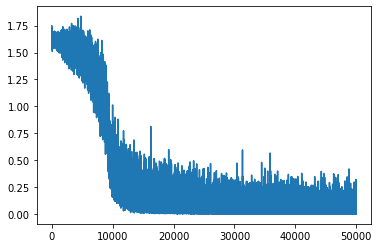

In [26]:
test_epochs = 1
for epoch in range(test_epochs):
    total = 0
    correct=0
    loader_iter = iter(test_dataloader)
    for batch in loader_iter:
        #################################################################################
        #                  COMPLETE THE FOLLOWING SECTION (5 points)                    #
        #################################################################################
        # report accuracy of your model.
        # plot loss values in whole training iterations.
        #################################################################################
        x, y = batch
        seq_size = N * K + 1
        one_hots = []
        last_targets = []
        for i in range (0,len(y),N+1):
          labels = set(y[i:i+N+1].tolist())
          map = {l : j  for j, l in enumerate(labels)}
          for j in range (N+1):
            y[i+j] = map[y[i+j].item()]

        one_hots = nn.functional.one_hot(y, num_classes = N)
        one_hots = one_hots.reshape((one_hots.shape[0]//seq_size, seq_size, -1))
        one_hots [:,-1,:] = torch.zeros(N)
        last_targets = []
        for i in range(one_hots.shape[0]):
          last_targets.append(y[(seq_size)*(i+1)-1])
        
        last_targets = torch.Tensor(last_targets).type(torch.LongTensor).to(device)
        one_hots = one_hots.to(device)
        x = x.to(device)

        with torch.no_grad():
          outputs = model(x, one_hots)

        _, pred = torch.max(outputs.data, 1)
        total += len(last_targets)
        correct += (pred == last_targets).sum().item()

    print ('acc on test:', correct/total*100)

plt.plot(losses)
plt.show()

        #################################################################################
        #                                   THE END                                     #
        #################################################################################

## Question (5 points)

Question) State one problem of using this network for meta-learning
<br><br>

Answer: 
It is obvious that if the tasks get more complex, due to the data driven nature of approach, the amount of data needed to get better results get higher and thus, the optimization gets more complex.
In addition, The depth of the TC block is determined by the sequence length. In few-shot classification, the sequence length can be known a prior.However, the sequence length is not determined for reinforcement learning tasks, and this may cause some problems.